In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png
/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv


In [65]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

data = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [66]:
import statsmodels
import statsmodels.api as sm

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample


In [67]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [68]:
data['last_review'] = pd.to_datetime(data['last_review'], format='%Y-%m-%d')

Preprocesing the data

In [69]:
data.isnull().sum().sort_values(ascending=False)
(data.isnull().sum())/(data.isnull().count().sort_values(ascending=False))

availability_365                  0.000000
calculated_host_listings_count    0.000000
host_id                           0.000000
host_name                         0.000429
id                                0.000000
last_review                       0.205583
latitude                          0.000000
longitude                         0.000000
minimum_nights                    0.000000
name                              0.000327
neighbourhood                     0.000000
neighbourhood_group               0.000000
number_of_reviews                 0.000000
price                             0.000000
reviews_per_month                 0.205583
room_type                         0.000000
dtype: float64

In [70]:
#data.drop(['host_name'], inplace=True, axis=1)
#data[data['number_of_reviews']==0]['reviews_per_month']
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [71]:
earliest = min(data['last_review'])
data['last_review'] = data['last_review'].fillna(earliest)
data['last_review'] = data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())


Regression for price of listing

In [72]:
import seaborn as sns
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
#sm.qqplot(data['price'], dist=stats.norm, fit=True, line='45', ax=ax[2])
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

Error in callback <function flush_figures at 0x7f7407dd5c80> (for post_execute):


KeyboardInterrupt: 

In [73]:

data = data[np.log1p(data['price'])<8]
data = data[np.log1p(data['price'])>3]
data.shape

(48784, 16)

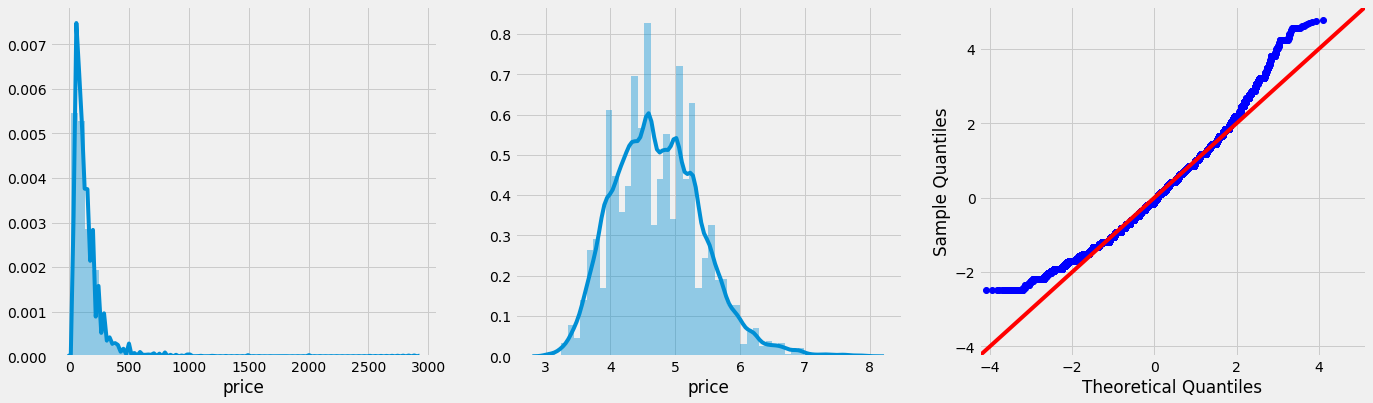

In [74]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
#sm.qqplot(data['price'], dist=stats.norm, fit=True, line='45', ax=ax[2])
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [75]:
data['price'] = np.log1p(data['price'])

In [76]:
data['host_id'].nunique()

37384

In [77]:
data['id'].nunique()

48784

In [78]:
data.drop(['id','host_id'], axis=1, inplace=True)


In [79]:
plt.figure(figsize=(20,20))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood', data=data)
plt.show()

KeyboardInterrupt: 

In [ ]:
data['minimum_nights']  = np.log1p(data['minimum_nights'])
sns.lmplot(x='minimum_nights', y='price1', data=data, height=4)
data['minimum_nights'] = np.log1p(data['minimum_nights'])

In [ ]:
sns.catplot(x='room_type', kind='count' ,data=data)

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))
sns.distplot(data['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[0])
sns.distplot(np.sqrt(data['reviews_per_month']), rug=True, kde=False, color="green", ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

In [ ]:
sns.scatterplot(x='reviews_per_month', y='price', data=data)

In [ ]:
data['all_year_avail'] = data['availability_365']>353
data['low_avail'] = data['availability_365']< 12

In [ ]:
data.shape

In [ ]:
cor_mat = data.corr()
fig, axes = plt.subplots(1,1,figsize=(15,12))
sns.heatmap(cor_mat, annot=True)

In [ ]:
data.drop(['name','host_name'], axis=1, inplace=True)
categorical = data.select_dtypes(include=('object'))
print('Categorical features: {}'.format(categorical.shape))

In [ ]:
data.head()

In [ ]:
cat_one_hot = pd.get_dummies(categorical)
cat_one_hot.head()

In [ ]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [ ]:
numerical_features = data.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

In [ ]:
X = np.concatenate((numerical_features, cat_one_hot), axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

In [ ]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [92]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 8194025991082.11523 +/- 10393991734450.734375
Ridge: 0.19458 +/- 0.006098
Lasso: 0.45210 +/- 0.006634
ElasticNet: 0.45141 +/- 0.006620


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestRegressor: 0.19360 +/- 0.004758


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor: 0.18407 +/- 0.006253
HuberRegressor: 0.20213 +/- 0.008852


In [ ]:
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
ridge_reg.score(X_train, y_train)

In [ ]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [ ]:
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

In [ ]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots(1,2,figsize=(21, 8))
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
axes[0].set_xscale('log')

cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
axes[1].set_xscale('log')

**Best alpha for regression**

In [ ]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
rr_cv_best = -rmse_cv(Ridge(alpha=best_alpha))
RR = Ridge(alpha=best_alpha)
RR.fit(X_train, y_train)
rr_train_predict = RR.predict(X_train)
rr_test_predict = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': rr_cv_best.mean(), 
            'CV std': rr_cv_best.std(),
            'training error': [mean_squared_error(y_train, rr_train_predict)],
            'test error': [mean_squared_error(y_test, rr_test_predict)],
            'training_r2_score': [r2_score(y_train, rr_train_predict)],
            'test_r2_score': [r2_score(y_test, rr_test_predict)]})
ridge_results

**Lasso Regression**

In [ ]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=3000)).mean() for alpha in alphas]

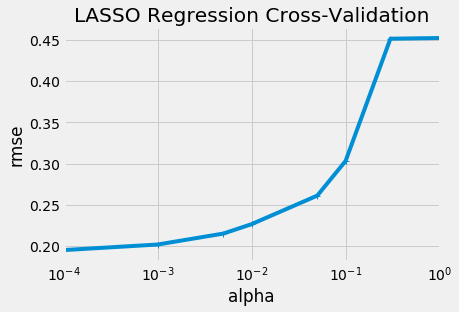

In [81]:
cv_lasso = pd.Series(cv_lasso, index = alphas) 
cv_lasso.plot(title = "LASSO Regression Cross-Validation", style='-+') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')

In [82]:
best_alpha = alphas[np.argmin(cv_lasso.values)]
lasso_CV_best = -rmse_cv(Lasso(alpha = best_alpha))
lasso = Lasso(alpha = best_alpha) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)
lasso_results = pd.DataFrame({'algorithm':['LASSO Regression'],
            'CV error': lasso_CV_best.mean(), 
            'CV std': lasso_CV_best.std(),
            'training error': [mean_squared_error(y_train_lasso, y_train)],
            'test error': [mean_squared_error(y_test_lasso, y_test)],
            'training_r2_score': [r2_score(y_train, y_train_lasso)],
            'test_r2_score': [r2_score(y_test, y_test_lasso)]})
lasso_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,LASSO Regression,0.195112,0.006097,0.193354,0.195301,0.579273,0.572874


In [94]:
features = list(cat_one_hot.columns) + list(numerical_features.columns)
coef = pd.Series(lasso.coef_, index = features)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
coef

Lasso picked 107 variables and eliminated the other 132 variables


neighbourhood_group_Bronx           -0.020877
neighbourhood_group_Brooklyn        -0.086414
neighbourhood_group_Manhattan       -0.128807
neighbourhood_group_Queens          -0.010991
neighbourhood_group_Staten Island   -0.052291
                                       ...   
reviews_per_month                    0.000000
calculated_host_listings_count      -0.057515
availability_365                     0.735907
all_year_avail                       0.000000
low_avail                           -0.388856
Length: 239, dtype: float64

In [89]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
cv_huber = [-rmse_cv(HuberRegressor(alpha = alpha)).mean() for alpha in alphas]

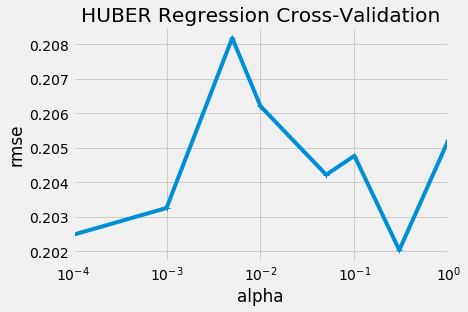

In [90]:
cv_huber = pd.Series(cv_huber, index = alphas) 
cv_huber.plot(title = "HUBER Regression Cross-Validation", style='-+') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')

In [91]:
best_alpha = alphas[np.argmin(cv_huber.values)]
huber_CV_best = -rmse_cv(HuberRegressor(alpha=best_alpha))
huber = HuberRegressor(alpha=best_alpha)
huber.fit(X_train, y_train) 
y_train_huber = huber.predict(X_train)
y_test_huber = huber.predict(X_test)
huber_results = pd.DataFrame({'algorithm':['Huber Regression'],
            'CV error': huber_CV_best.mean(), 
            'CV std': huber_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_huber)],
            'test error': [mean_squared_error(y_test, y_test_huber)],
            'training_r2_score': [r2_score(y_train, y_train_huber)],
            'test_r2_score': [r2_score(y_test, y_test_huber)]})
huber_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Huber Regression,0.202036,0.007081,0.205619,0.20531,0.552584,0.550984


In [103]:
lasso_coef = coef[coef!=0]
X_df = pd.concat([numerical_features, cat_one_hot], axis=1)
Xlv = X_df[list(lasso_coef.index)]

In [108]:
Xlv_train, Xlv_test, y_train, y_test = train_test_split(Xlv, y, test_size=0.2, random_state=42)
print('Dimensions of the training feature matrix for lasso variable selection: {}'.format(Xlv_train.shape))
print('Dimensions of the test feature matrix for lasso variable selection: {}'.format(Xlv_test.shape))

Dimensions of the training feature matrix for lasso variable selection: (39027, 107)
Dimensions of the test feature matrix for lasso variable selection: (9757, 107)


In [109]:
n_folds = 5

# squared_loss
def rmse_cv_lv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [110]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_cv_lv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 2354991442478555.00000 +/- 4187058399487140.000000
Ridge: 0.35281 +/- 0.006882
Lasso: 0.44959 +/- 0.006019
ElasticNet: 0.44857 +/- 0.005982


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestRegressor: 0.33572 +/- 0.005793


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor: 0.18407 +/- 0.006253
HuberRegressor: 0.36999 +/- 0.007251
